In [2]:
import torch
import os
import json
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
import importlib.util
from matplotlib.lines import Line2D


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
input_type = 'delocalized'
folder_path = f'/vast/sr6364/perturbed_organics/data/curves/{input_type}/'

In [4]:

# This dictionary will map each tensor name (file name without .pt)
# to a dictionary that maps deltaval values to the loaded tensor.
all_data = {}

# Regular expression to capture a deltaval value at the end of the folder name.
# For example, if the folder name is "commonText_deltaval_1.0",
# this regex extracts "1.0".
pattern = re.compile(r'_delta_([0-9\.]+)$')

# Loop over all items in the main folder
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        match = pattern.search(subfolder)
        if match:
            # Convert the captured deltaval string to a float
            deltaval = float(match.group(1))
            
            # Loop over each file in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.pt'):
                    # Use the file name without the extension as the tensor name
                    tensor_name = os.path.splitext(filename)[0]
                    # Load the torch tensor from file
                    tensor = torch.load(os.path.join(subfolder_path, filename))
                    
                    # If this tensor name has not been seen before, create a new dictionary for it.
                    if tensor_name not in all_data:
                        all_data[tensor_name] = {}
                    
                    # Save the tensor in the inner dictionary with deltaval as key.
                    all_data[tensor_name][deltaval] = tensor



In [5]:
param_file_path = os.path.join(folder_path, subfolder, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [6]:
all_data.keys()

dict_keys(['actual_fixed_point_a', 'actual_fixed_point_y', 'bool_stable', 'eigvals_J', 'first_order_perturb_a', 'first_order_perturb_y', 'norm_fixed_point_a', 'norm_fixed_point_y', 'percent_stable', 'spectral_radius'])

In [7]:
actual_fp_y_dict = all_data['actual_fixed_point_y']
norm_fp_y_dict = all_data['norm_fixed_point_y']
eigvals_dict = all_data['eigvals_J']

### We plot the mean and variance of the membrane potential for a given neuron as a function of input drive

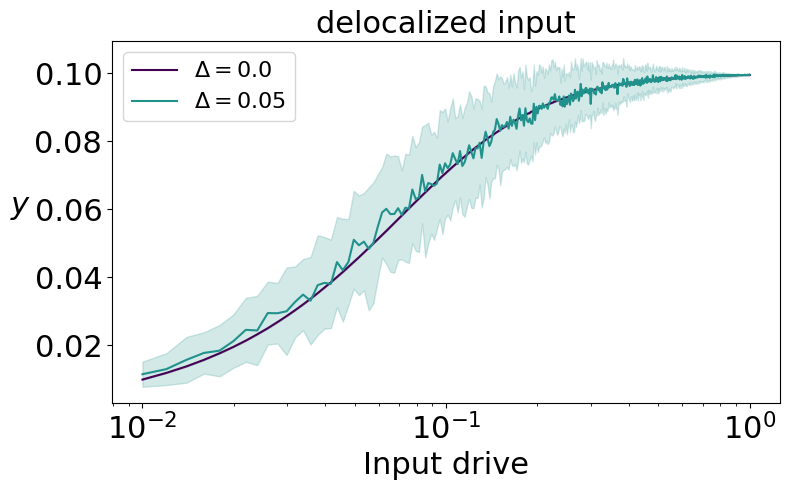

In [20]:
plt.figure(figsize=(8, 5))

idx = N // 2 # index of the neuron to plot the vals for

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [0.0, 0.05]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx]

    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_val_mean = torch.nanmean(y_val, dim=2)

    # y_val_std = torch.std(y_val, dim=2) / np.sqrt(num_trials)
    y_val_std = torch.std(y_val, dim=2) 

    plot = plt.plot(input_range, y_val_mean[0, :], label=f"$\Delta = {delta_val}$", color=plt.cm.viridis(i / len(delta_keys)))
    plt.fill_between(input_range, y_val_mean[0, :] - y_val_std[0, :], y_val_mean[0, :] + y_val_std[0, :], alpha=0.2, color=plt.cm.viridis(i / len(delta_keys)))

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$y$", fontsize=22, rotation=0, labelpad=10)
plt.title(f"{input_type} input", fontsize=22)
# plot x axis logscale
plt.xscale('log')
# plt.ylim([-0.05, 2])
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

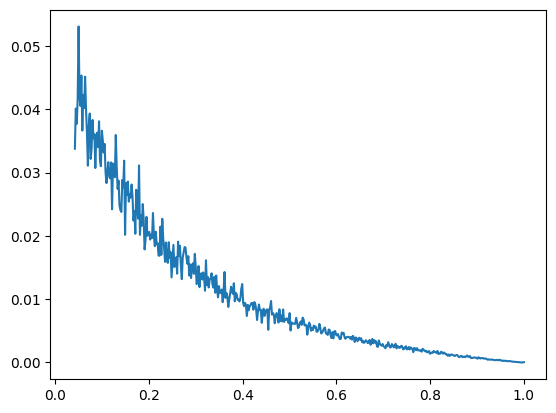

In [38]:
plt.plot(input_range, y_val_std[0, :])
# save input_range and y_val_std[0, :] to a two column txt file
np.savetxt(f'{input_type}_input_std.txt', np.vstack((input_range, y_val_std[0, :])).T)

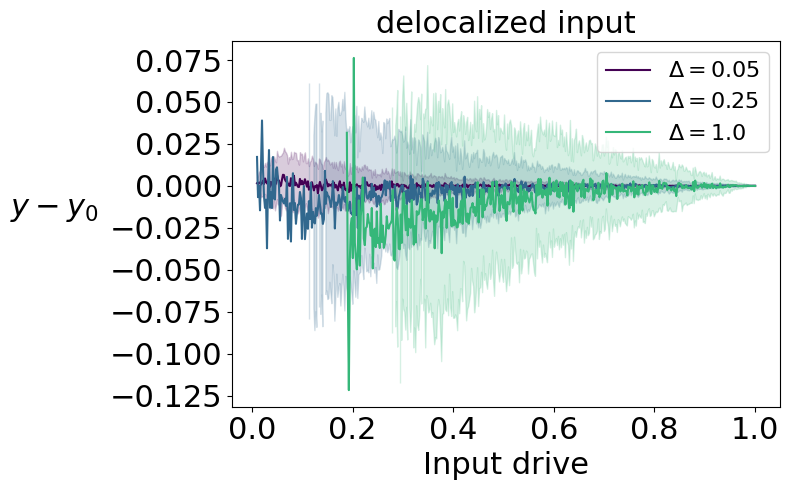

In [28]:
plt.figure(figsize=(8, 5))

idx = N // 2 # index of the neuron to plot the vals for

# Get all the delta values and sort them (assuming they are numeric)
# delta_keys = sorted(actual_fp_y_dict.keys())
delta_keys = [0.05, 0.25, 1.0]
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]

    y_val = actual_fp_y[:, :, :, idx] - norm_fixed_point_y[:, :, :, idx]

    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_val_mean = torch.nanmean(y_val, dim=2)

    # y_val_std = torch.std(y_val, dim=2) / np.sqrt(num_trials)
    y_val_std = torch.std(y_val, dim=2) 

    plot = plt.plot(input_range, y_val_mean[0, :], label=f"$\Delta = {delta_val}$", color=plt.cm.viridis(i / len(delta_keys)))
    plt.fill_between(input_range, y_val_mean[0, :] - y_val_std[0, :], y_val_mean[0, :] + y_val_std[0, :], alpha=0.2, color=plt.cm.viridis(i / len(delta_keys)))

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$y - y_0$", fontsize=22, rotation=0, labelpad=40)
plt.title(f"{input_type} input", fontsize=22)
# plt.ylim([-0.05, 2])
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

### Plotting the ratio of away from normalization

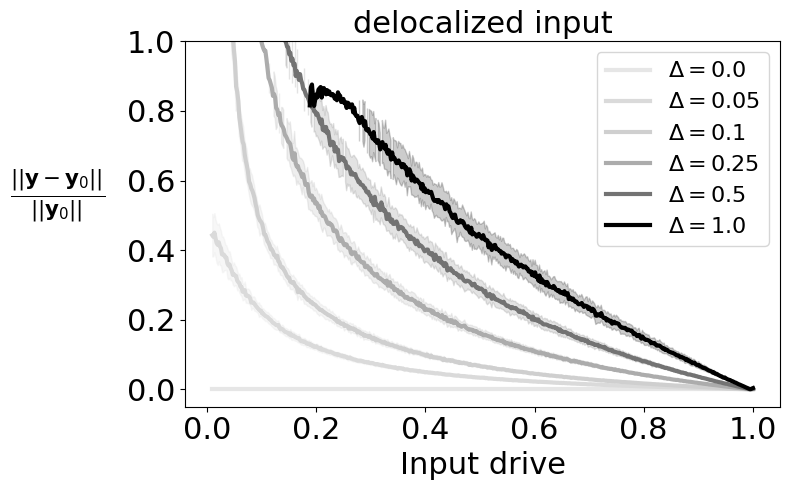

In [27]:

plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(actual_fp_y_dict.keys())
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for delta_val in delta_keys:
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]
    y_ratio = torch.norm(norm_fixed_point_y - actual_fp_y, dim=3) / torch.norm(norm_fixed_point_y, dim=3)
    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_ratio_mean = torch.nanmean(y_ratio, dim=2)

    y_ratio_std = torch.std(y_ratio, dim=2) 
    
    # Normalize delta_val to the range [0, 1]
    if max_delta > min_delta:
        norm_val = (delta_val - min_delta) / (max_delta - min_delta)
    else:
        norm_val = 0  # Avoid division by zero if all delta values are the same
    
    # Map the normalized value to a grayscale intensity in the range [0, 0.25]
    # (0.25 is lightest; 0 is black)
    grayscale_value = 0.9 * (1 - norm_val)
    
    # Plot using the computed grayscale value. Matplotlib interprets strings like "0.25" as a grayscale color.
    plt.plot(input_range, y_ratio_mean[0, :],
             label=f"$\\Delta = {delta_val}$",
             linewidth=3,
             color=str(grayscale_value))
    
    plt.fill_between(input_range, y_ratio_mean[0, :] - y_ratio_std[0, :], y_ratio_mean[0, :] + y_ratio_std[0, :], alpha=0.2, color=str(grayscale_value))


plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||}{||\mathbf{y}_0||}$", fontsize=22, rotation=0, labelpad=50)
plt.title(f"{input_type} input", fontsize=22)
plt.ylim([-0.05, 1])
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

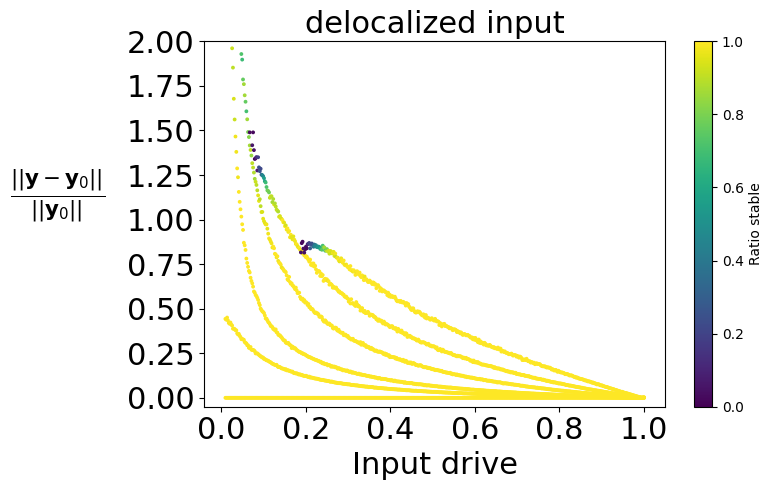

In [46]:
plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(actual_fp_y_dict.keys())

for i, delta_val in enumerate(delta_keys):
    actual_fp_y = actual_fp_y_dict[delta_val]
    norm_fixed_point_y = norm_fp_y_dict[delta_val]
    y_ratio = torch.norm(norm_fixed_point_y - actual_fp_y, dim=3) / torch.norm(norm_fixed_point_y, dim=3)
    ratio_stable = torch.sum(~torch.isnan(y_ratio), dim=2) / num_trials

    # y_ratio_mean = torch.mean(y_ratio, dim=2)
    y_ratio_mean = torch.nanmean(y_ratio, dim=2)

    scatter = plt.scatter(input_range, y_ratio_mean[0, :], cmap='viridis', c=ratio_stable, vmin=0, vmax=1, s=3, marker='o')

plt.xlabel('Input drive', fontsize=22)
plt.ylabel(r"$\frac{||\mathbf{y}-\mathbf{y}_0||}{||\mathbf{y}_0||}$", fontsize=22, rotation=0, labelpad=50)
plt.title(f"{input_type} input", fontsize=22)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio stable')
plt.ylim([-0.05, 2])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

### Plotting the max real part of eigenvalue of the jacobian

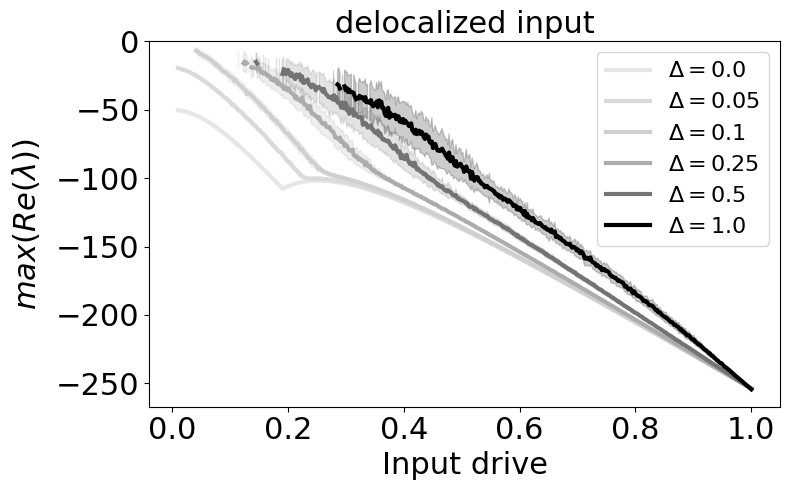

In [30]:
plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(eigvals_dict.keys())
min_delta = min(delta_keys)
max_delta = max(delta_keys)

for delta_val in delta_keys:
    eigvals_J = eigvals_dict[delta_val]
    eigvals_J_real = torch.max(torch.real(eigvals_J), dim=3).values
    eigvals_J_real_mean = torch.mean(eigvals_J_real, dim=2)
    # eigvals_J_real_mean = torch.nanmean(eigvals_J_real, dim=2)
    # eigvals_J_real_mean = torch.max(eigvals_J_real, dim=2).values

    eigvals_J_real_std = torch.std(eigvals_J_real, dim=2) 
    
    # Normalize delta_val to the range [0, 1]
    if max_delta > min_delta:
        norm_val = (delta_val - min_delta) / (max_delta - min_delta)
    else:
        norm_val = 0  # Avoid division by zero if all delta values are the same
    
    # Map the normalized value to a grayscale intensity in the range [0, 0.25]
    # (0.25 is the lightest color; 0 is black)
    grayscale_value = 0.9 * (1 - norm_val)
    
    # Plot using the computed grayscale value. Matplotlib interprets strings like "0.25" as a grayscale color.
    plt.plot(input_range, eigvals_J_real_mean[0, :],
             label=f"$\\Delta = {delta_val}$",
             linewidth=3,
             color=str(grayscale_value))

    plt.fill_between(input_range, eigvals_J_real_mean[0, :] - eigvals_J_real_std[0, :], eigvals_J_real_mean[0, :] + eigvals_J_real_std[0, :], alpha=0.2, color=str(grayscale_value))


plt.xlabel('Input drive', fontsize=22)
plt.ylabel(f"$max(Re(\\lambda))$", fontsize=22, rotation=90, labelpad=10)
plt.title(f"{input_type} input", fontsize=22)
plt.gca().set_ylim(top=0)
plt.legend(fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

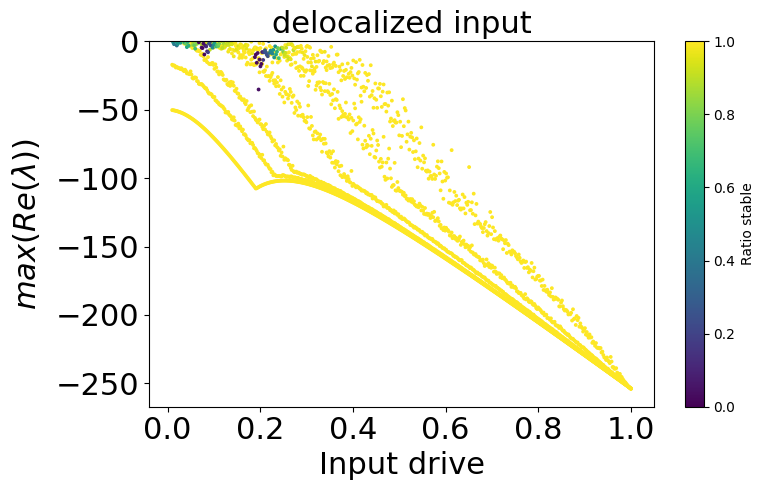

In [43]:
plt.figure(figsize=(8, 5))

# Get all the delta values and sort them (assuming they are numeric)
delta_keys = sorted(eigvals_dict.keys())

for delta_val in delta_keys:
    eigvals_J = eigvals_dict[delta_val]
    eigvals_J_real = torch.max(torch.real(eigvals_J), dim=3).values

    ratio_stable = torch.sum(~torch.isnan(eigvals_J_real), dim=2) / num_trials

    # eigvals_J_real_mean = torch.mean(eigvals_J_real, dim=2)
    # eigvals_J_real_mean = torch.nanmean(eigvals_J_real, dim=2)
    eigvals_J_real_mean = torch.max(torch.nan_to_num(eigvals_J_real, nan=-float('inf')), dim=2).values
    
    scatter = plt.scatter(input_range, eigvals_J_real_mean[0, :], cmap='viridis', c=ratio_stable, vmin=0, vmax=1, s=3, marker='o')


plt.xlabel('Input drive', fontsize=22)
plt.ylabel(f"$max(Re(\\lambda))$", fontsize=22, rotation=90, labelpad=10)
plt.title(f"{input_type} input", fontsize=22)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio stable')
plt.gca().set_ylim(top=0)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.show()

In [36]:
eigvals_J_real[mask].shape

torch.Size([25000])